In [243]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from typing import Union,Sequence
%matplotlib inline
import pandas as pd
from skimage.color import label2rgb
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import seaborn as sns
from atommic.collections.reconstruction.losses.haarpsi import haarpsi
import functools
from atommic.collections.segmentation.losses.dice import Dice
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import gaussian_filter


In [244]:
# Function for plotting MRI scans



def get_scaled_image(
    x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
  """Scales image by intensity percentile (and optionally clips to [0, 1]).

  Args:
    x (torch.Tensor | np.ndarray): The image to process.
    percentile (float): The percentile of magnitude to scale by.
    clip (bool): If True, clip values between [0, 1]

  Returns:
    torch.Tensor | np.ndarray: The scaled image.
  """
  is_numpy = isinstance(x, np.ndarray)
  if is_numpy:
    x = torch.as_tensor(x)

  scale_factor = torch.quantile(x, percentile)
  x = x / scale_factor
  if clip:
    x = torch.clip(x, 0, 1)

  if is_numpy:
    x = x.numpy()

  return x


def plot_images(
    images, processor=None, disable_ticks=True, titles: Sequence[str]=None,
    ylabel: str=None, xlabels: Sequence[str]=None, cmap: str="gray",
    show_cbar: bool = False, overlay = None, opacity: float = 0.3,
    hsize=5, wsize=5, axs=None,fontsize =20
):
  """Plot multiple images in a single row.

  Add an overlay with the `overlay=` argument.
  Add a colorbar with `show_cbar=True`.
  """
  def get_default_values(x, default=""):
    if x is None:
      return [default] * len(images)
    return x

  titles = get_default_values(titles)
  ylabels = get_default_values(images)
  xlabels = get_default_values(xlabels)

  N = len(images)
  if axs is None:
    fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
  else:
    assert len(axs) >= N
    fig = axs.flatten()[0].get_figure()
  k = 0
  for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
    if processor is not None:
      img = processor(img)
    if type(cmap)==list:
        im = ax.imshow(img, cmap=cmap[k])
        if type(show_cbar)==list:
            if show_cbar[k]:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
                fig.colorbar(im, cax=cbar_ax)
    else:
      im = ax.imshow(img, cmap=cmap)
    k = k+1
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xlabel)


  if type(overlay) ==list:
    for i,ax in enumerate(axs.flatten()):
      if overlay[i] is not None:
        im = ax.imshow(overlay[i], alpha=opacity)


  if disable_ticks:
    for ax in axs.flatten():
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])

  return axs


In [245]:
# Function for transforming segmentation classes into categorical
def one_hot_to_categorical(x, channel_dim: int = 1, background=False):
    """Converts one-hot encoded predictions to categorical predictions.

    Args:
        x (torch.Tensor | np.ndarray): One-hot encoded predictions.
        channel_dim (int, optional): Channel dimension.
            Defaults to ``1`` (i.e. ``(B,C,...)``).
        background (bool, optional): If ``True``, assumes index 0 in the
            channel dimension is the background.

    Returns:
        torch.Tensor | np.ndarray: Categorical array or tensor. If ``background=False``,
        the output will be 1-indexed such that ``0`` corresponds to the background.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.as_tensor(x)

    if background is not None and background is not False:
        out = torch.argmax(x, channel_dim)
    else:
        out = torch.argmax(x.type(torch.long), dim=channel_dim) + 1
        out = torch.where(x.sum(channel_dim) == 0, torch.tensor([0], device=x.device), out)

    if is_ndarray:
        out = out.numpy()
    return out

In [246]:
def haarpsi3d(x: np.ndarray, y: np.ndarray, seg: np.ndarray = np.array([]),maxval: np.ndarray = None) -> float:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if x.ndim == 2:
        x = x[np.newaxis, :, :]
    if y.ndim == 2:
        y = y[np.newaxis, :, :]
    if seg.ndim == 2:
        seg = seg[np.newaxis, :, :]
    if x.ndim != 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if x.ndim != y.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")
    reduction = 'mean'
    scales = 3
    subsample = True
    c = 30.0
    alpha = 4.2

    maxval = np.max(x) if maxval is None else maxval
    _haarpsi = functools.partial(haarpsi, scales=scales, subsample=subsample, c=c, alpha=alpha,
                                 data_range=maxval, reduction=reduction)
    if np.size(seg)==0:
        __haarpsi = sum(
            _haarpsi(torch.from_numpy(x[slice_num]).unsqueeze(0).float(),
                     torch.from_numpy(y[slice_num]).unsqueeze(0).float()) for slice_num in
            range(x.shape[0])
        ).numpy()
    else:
        __haarpsi = []
        for slice_num in range(x.shape[0]):
            x_seg = x[slice_num]*seg[slice_num]
            y_seg = y[slice_num]*seg[slice_num]
            non_zero_coord = np.column_stack(np.where(x_seg>0))
            if np.size(non_zero_coord) >0:
                min_x, min_y = np.min(non_zero_coord,axis = 0)
                max_x, max_y = np.max(non_zero_coord,axis = 0)
                y_seg = y_seg[min_x:max_x,min_y:max_y]
                x_seg = x_seg[min_x:max_x,min_y:max_y]
                max_val = max(np.max(x_seg),np.max(y_seg))
                functools.partial(haarpsi, scales=scales, subsample=subsample, c=c, alpha=alpha,
                                 data_range=maxval, reduction=reduction)
                __haarpsi.append(_haarpsi(torch.from_numpy(x_seg).unsqueeze(0).float(),
                     torch.from_numpy(y_seg).unsqueeze(0).float()))
        __haarpsi=sum(__haarpsi)

    return __haarpsi / x.shape[0]

In [247]:
def ssim(x: np.ndarray, y: np.ndarray, seg: np.ndarray = np.array([]),maxval: np.ndarray = None) -> float:
    """Computes Structural Similarity Index Measure (SSIM).

    Parameters
    ----------
    x : np.ndarray
        Target image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D images,
        the first dimension should be 1.
    y : np.ndarray
        Predicted image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D
        images, the first dimension should be 1.
    maxval : np.ndarray
        Maximum value of the images. If None, it is computed from the images. If the images are normalized, maxval
        should be 1.

    Returns
    -------
    float
        Structural Similarity Index Measure.

    Examples
    --------
    >>> from atommic.collections.reconstruction.metrics.reconstruction_metrics import ssim
    >>> import numpy as np
    >>> datax = np.random.rand(3, 100, 100)
    >>> datay = datax * 0.5
    >>> ssim(datax, datay)
    0.01833040155119426

    .. note::
        x and y must be normalized to the same range, e.g. [0, 1].

        The SSIM is computed using the scikit-image implementation of the SSIM metric.
        Source: https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.structural_similarity
    """
    if x.ndim == 2:
        x = x[np.newaxis, :, :]
    if y.ndim == 2:
        y = y[np.newaxis, :, :]
    if seg.ndim == 2:
        seg = seg[np.newaxis, :, :]
    if x.ndim != 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if x.ndim != y.ndim:
        raise ValueError("Ground truth dimensions does not match prediction dimensions.")

    maxval = max(np.max(x) - np.min(x), np.max(y) - np.min(y)) if maxval is None else maxval
    maxval = max(maxval, 1)
    if np.size(seg)==0:
        ssim_score = sum(
        structural_similarity(x[slice_num], y[slice_num], data_range=maxval) for slice_num in range(x.shape[0])
    )
    else:
        ssim_score = []
        for slice_num in range(x.shape[0]):
            x_seg = x[slice_num]*seg[slice_num]
            y_seg = y[slice_num]*seg[slice_num]
            non_zero_coord = np.column_stack(np.where(x_seg>0))
            if np.size(non_zero_coord) >0:
                min_x, min_y = np.min(non_zero_coord,axis = 0)
                max_x, max_y = np.max(non_zero_coord,axis = 0)
                y_seg = y_seg[min_x:max_x,min_y:max_y]
                x_seg = x_seg[min_x:max_x,min_y:max_y]
                #maxval = max(np.max(x_seg) - np.min(x_seg), np.max(y_seg) - np.min(y_seg))
                ssim_score.append(structural_similarity(x_seg, y_seg, data_range=maxval))
        ssim_score = sum(ssim_score)
    return ssim_score / x.shape[0]

In [248]:
def dice_metric(
    x: torch.Tensor,
    y: torch.Tensor,
    include_background: bool = False,
    to_onehot_y: bool = False,
    sigmoid: bool = False,
    softmax: bool = False,
    other_act: Union[str, None] = None,
    squared_y: bool = False,
    jaccard: bool = False,
    flatten: bool = False,
    reduction: Union[str, None] = "mean_batch",
    smooth_nr: float = 1e-5,
    smooth_dr: float = 1e-5,
    batch: bool = True,
) -> float:
    """Compute Dice Score.

    Parameters
    ----------
    x : torch.Tensor
        Ground Truth Tensor.
    y : torch.Tensor
        Prediction Tensor.
    include_background : bool
        Whether to skip Dice computation on the first channel of the predicted output. Default is ``True``.
    to_onehot_y : bool
        Whether to convert `y` into the one-hot format. Default is ``False``.
    sigmoid : bool
        Whether to add sigmoid function to the input data. Default is ``True``.
    softmax : bool
        Whether to add softmax function to the input data. Default is ``False``.
    other_act : Union[str, None]
        Use this parameter if you want to apply another type of activation layer. Default is ``None``.
    squared_y : bool
        Whether to square the prediction before calculating Dice. Default is ``False``.
    jaccard : bool
        Whether to compute Jaccard Index as a loss. Default is ``False``.
    flatten : bool
        Whether to flatten input data. Default is ``False``.
    reduction : Union[str, None]
        Specifies the reduction to apply to the output: ``none`` | ``mean`` | ``sum``.
        ``none``: no reduction will be applied. ``mean``: the sum of the output will be divided by the number of
        elements. ``sum``: the output will be summed. Default is ``mean``.
    smooth_nr : float
        A small constant added to the numerator to avoid ``nan`` when all items are 0.
    smooth_dr : float
        A small constant added to the denominator to avoid ``nan`` when all items are 0.
    batch : bool
        If True, compute Dice loss for each batch and return a tensor with shape (batch_size,).
        If False, compute Dice loss for the whole batch and return a tensor with shape (1,).
        Default is ``True``.
    Returns
    -------
    float
        Dice Score.

    Examples
    --------
    >>> from atommic.collections.segmentation.metrics.segmentation_metrics import dice_metric
    >>> import torch
    >>> datax = torch.randint(0, 2, (3, 2, 100, 100))
    >>> datay = torch.randint(0, 2, (3, 2, 100, 100))
    >>> dice_metric(datax, datay)
    0.5016108751296997
    """
    custom_dice = Dice(
        include_background=include_background,
        to_onehot_y=to_onehot_y,
        sigmoid=sigmoid,
        softmax=softmax,
        other_act=other_act,  # type: ignore
        squared_pred=squared_y,
        jaccard=jaccard,
        flatten=flatten,
        reduction=reduction,  # type: ignore
        smooth_nr=smooth_nr,
        smooth_dr=smooth_dr,
        batch=batch,
    )
    dice_score, _ = custom_dice(x, y)
    return dice_score.item()

In [249]:
def hausdorff_distance_metric(x: torch.Tensor, y: torch.Tensor, batched: bool = True, sum_method='max') -> float:
    """Compute Hausdorff Distance.

    The Hausdorff distance is computed as the maximum between x to y and y to x.

    Parameters
    ----------
    x : torch.Tensor
        Ground Truth Tensor.
    y : torch.Tensor
        Prediction Tensor.
    batched : bool
        If True, compute Hausdorff distance for each batch and return a tensor with shape (batch_size,).
        If False, compute Hausdorff distance for the whole batch and return a tensor with shape (1,).
        Default is ``True``.
    sum_method : str
        Method to sum the 95th percentile of the Hausdorff Distance. Default is ``max``, which argmax the 95th
        percentile of the Hausdorff Distance. If ``sum``, sum the 95th percentile of the Hausdorff Distance.

    Returns
    -------
    float
        Hausdorff Distance.

    Examples
    --------
    >>> from atommic.collections.segmentation.metrics.segmentation_metrics import hausdorff_distance_metric
    >>> import torch
    >>> datax = torch.randint(0, 2, (3, 2, 100, 100))
    >>> datay = torch.randint(0, 2, (3, 2, 100, 100))
    >>> hausdorff_distance_metric(datax, datay)
    5.858907404245753
    """
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if isinstance(y, np.ndarray):
        y = torch.from_numpy(y)
    if batched:
        hd = []
        for sl in range(x.shape[0]):
            hdx = x[sl].float().argmax(0).numpy() if sum_method == 'max' else x[sl].float().sum(0).numpy()
            hdy = y[sl].float().argmax(0).numpy() if sum_method == 'max' else y[sl].float().sum(0).numpy()
            hd.append(max(directed_hausdorff(hdx, hdy)[0], directed_hausdorff(hdy, hdx)[0]))
        return sum(hd) / len(hd)

    x = x.float().argmax(0).numpy() if sum_method == 'max' else x.float().sum(0).numpy()
    y = y.float().argmax(0).numpy() if sum_method == 'max' else y.float().sum(0).numpy()
    return max(directed_hausdorff(x, y)[0], directed_hausdorff(y, x)[0])

In [250]:
def complex_abs(x: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.

    Parameters
    ----------
    x : torch.Tensor
        Complex tensor. The last dimension must be of size 2.

    Returns
    -------
    torch.Tensor
        Absolute value of complex tensor.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import complex_abs
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> complex_abs(data)
    tensor([1.4142, 2.8284, 4.2426])
    """
    if x.shape[-1] != 2:
        if torch.is_complex(x):
            x = torch.view_as_real(x)
        else:
            raise ValueError("Tensor does not have separate complex dim.")
    return (x**2).sum(dim=-1)

In [251]:
def check_stacked_complex(x: torch.Tensor) -> torch.Tensor:
    """
    Check if tensor is stacked complex (real & imaginary parts stacked along last dim) and convert it to a combined
    complex tensor.

    Parameters
    ----------
    x : torch.Tensor
        Tensor to check.

    Returns
    -------
    torch.Tensor
        Tensor with stacked complex converted to combined complex.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import check_stacked_complex
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> data = torch.view_as_real(data)
    >>> data.shape
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    """
    return torch.view_as_complex(x) if x.shape[-1] == 2 else x

In [274]:
fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-03/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs_1 = f['reconstruction'][()].squeeze()
    segmentations_mtlrs_1  = f['segmentation'][()].squeeze()
    target_mtlrs_1  = f['target_reconstruction'][()].squeeze()
    segmentation_labels_org_1  = f['target_segmentation'][()].squeeze()
    loglike_mtlrs_1  = f['intermediate_loglike'][()].squeeze()
    zero_filled_mtlrs_1  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_1  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_1 .shape,predictions_1 .shape,segmentation_labels_org_1 .shape,target_mtlrs_1 .shape, loglike_mtlrs_1 .shape,inter_rec_1 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-21/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs_2 = f['reconstruction'][()].squeeze()
    segmentations_mtlrs_2  = f['segmentation'][()].squeeze()
    #target_mtlrs_2  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_2  = f['target_segmentation'][()].squeeze()
    loglike_mtlrs_2  = f['intermediate_loglike'][()].squeeze()
    #zero_filled_mtlrs_2  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_2  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_2 .shape,predictions_2 .shape,segmentation_labels_org_2 .shape,target_mtlrs_2 .shape, loglike_mtlrs_2 .shape,inter_rec_2 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-29/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # print(f.keys())
    scan_mtlrs_3 = f['reconstruction'][()].squeeze()
    segmentations_mtlrs_3  = f['segmentation'][()].squeeze()
    #target_mtlrs_3  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_3  = f['target_segmentation'][()].squeeze()
    loglike_mtlrs_3  = f['intermediate_loglike'][()].squeeze()
    # zero_filled_3  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_3  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
print(scan_mtlrs_3.dtype)
print(scan_mtlrs_1.dtype)
print(scan_mtlrs_2.dtype)

<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
complex64
complex64
complex64


In [ ]:
print(segmentation_labels_org_1.shape)

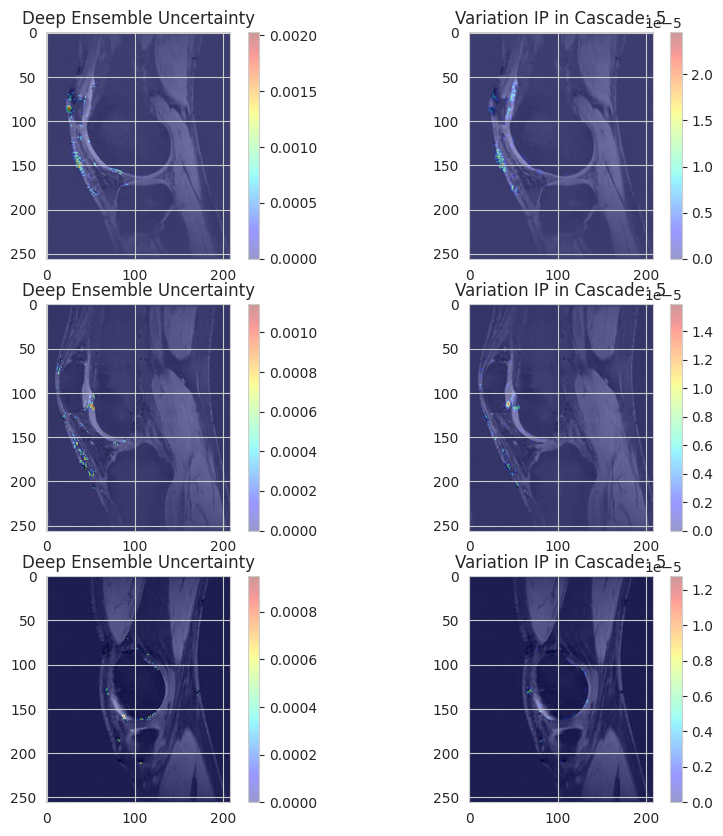

In [284]:

echo=0
c=4
alpha = 0.5
std_MTLRS = np.var(np.array([inter_rec_mtlrs_1[:,0,c,echo],inter_rec_mtlrs_2[:,0,c,echo],inter_rec_mtlrs_3[:,0,c,echo]]),axis=0)*target
std_MTLRS = gaussian_filter(std_MTLRS,alpha)
std_MTLRS[std_MTLRS< 0.0005] = 0
blur_inter_rec_mtlrs_3= gaussian_filter(np.power(inter_rec_mtlrs_3[:,1,c,echo],2),alpha)
blur_inter_rec_mtlrs_3[blur_inter_rec_mtlrs_3<0.000003] = 0
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)

plt.imshow(scan_mtlrs_3[20,echo,:,:].real,cmap='gray')
plt.imshow(std_MTLRS[20,:,:].real,alpha=0.4,cmap='jet')
plt.title("Deep Ensemble Uncertainty")
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(inter_rec_mtlrs_3[20,0,c,echo,:,:].real,cmap='gray')
plt.imshow(blur_inter_rec_mtlrs_3[20].real,alpha=0.4,cmap='jet')
plt.title(f"Variation IP in Cascade: {c+1}")
plt.colorbar()
plt.subplot(3,2,3)
plt.imshow(scan_mtlrs_3[40,echo,:,:].real,cmap='gray')
plt.imshow(std_MTLRS[40,:,:].real,alpha=0.4,cmap='jet')
plt.title("Deep Ensemble Uncertainty")
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(inter_rec_mtlrs_3[40,0,c,echo,:,:].real,cmap='gray')
plt.imshow(blur_inter_rec_mtlrs_3[40].real,alpha=0.4,cmap='jet')
plt.title(f"Variation IP in Cascade: {c+1}")
plt.colorbar()
plt.subplot(3,2,5)
plt.imshow(scan_mtlrs_3[60,echo,:,:].real,cmap='gray')
plt.imshow(std_MTLRS[60,:,:].real,alpha=0.4,cmap='jet')
plt.title("Deep Ensemble Uncertainty")
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(inter_rec_mtlrs_3[60,0,c,echo,:,:].real,cmap='gray')
plt.imshow(blur_inter_rec_mtlrs_3[60].real,alpha=0.4,cmap='jet')
plt.title(f"Variation IP in Cascade: {c+1}")
plt.colorbar()
plt.show()

In [254]:

plt.figure()

un_max_mtlrs_1 = [np.max(std_MTLRS[:,0,i,0].reshape(1,-1)).real for i in range(std_MTLRS.shape[2])]
data_frame = pd.DataFrame({'MTLRS_1':un_max_mtlrs_1,'Cascades':[1,2,3,4,5]})
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_1, label= f"Std softmax MTL",color="blue")
un_max_mtlrs_1 = [np.max(np.sqrt(inter_rec_mtlrs_1[:,1,i,0].reshape(1,-1))).real for i in range(inter_rec_mtlrs_1.shape[2])]
data_frame = pd.DataFrame({'MTLRS_1':un_max_mtlrs_1,'Cascades':[1,2,3,4,5]})
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_1, label= f"Var softmax MTL",color="red")
plt.title("Mean std of each intermediate logliklihood gradient for each cascade")
plt.ylabel('Standard Deviation')
plt.show()

ValueError: All arrays must be of the same length

<Figure size 640x480 with 0 Axes>

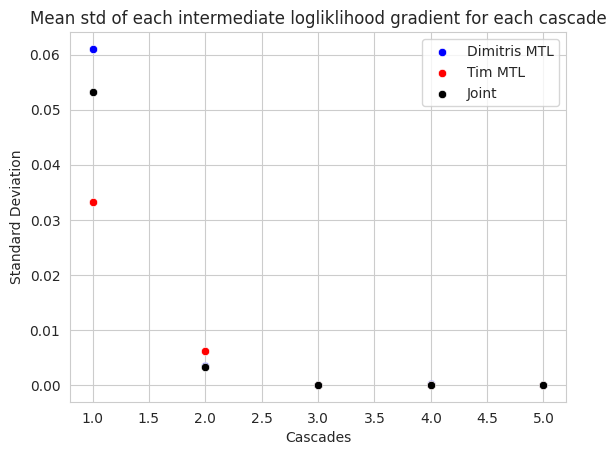

In [52]:
plt.figure()
for idx in [10]:
    un_max_mtlrs_1 = [np.mean(loglike_mtlrs_1[idx,1,i,0].reshape(1,-1)).real for i in range(loglike_mtlrs_1.shape[2])]
    un_max_mtlrs_2 = [np.mean(loglike_mtlrs_2[idx,1,i,0].reshape(1,-1)).real for i in range(loglike_mtlrs_2.shape[2])]
    un_max_mtlrs_3 = [np.mean(loglike_mtlrs_3[idx,1,i,0].reshape(1,-1)).real for i in range(loglike_mtlrs_3.shape[2])]
    data_frame = pd.DataFrame({'MTLRS_1':un_max_mtlrs_1,'MTLRS_2':un_max_mtlrs_2,'MTLRS_3':un_max_mtlrs_3,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_1, label= f"Dimitris MTL",color="blue")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_2, label= f"Tim MTL",color="red")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_3, label= f"Joint",color="black")

plt.title("Mean std of each intermediate logliklihood gradient for each cascade")
plt.ylabel('Standard Deviation')
plt.show()

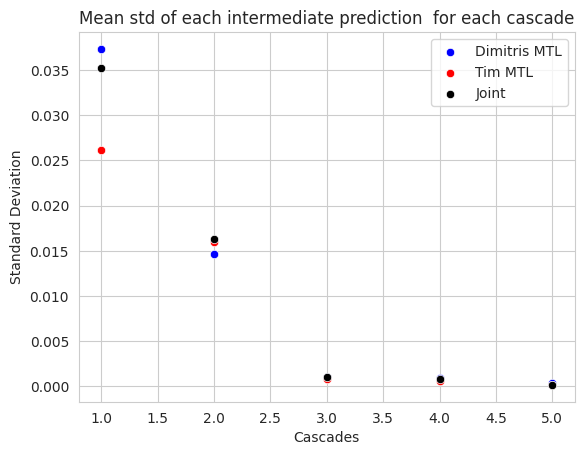

In [54]:
for idx in [10]:
    un_max_mtlrs_1 = [np.mean(inter_rec_mtlrs_1[idx,1,i,0].reshape(1,-1)).real for i in range(inter_rec_mtlrs_1.shape[2])]
    un_max_mtlrs_2 = [np.mean(inter_rec_mtlrs_2[idx,1,i,0].reshape(1,-1)).real for i in range(inter_rec_mtlrs_2.shape[2])]
    un_max_mtlrs_3 = [np.mean(inter_rec_mtlrs_3[idx,1,i,0].reshape(1,-1)).real for i in range(inter_rec_mtlrs_3.shape[2])]

    data_frame = pd.DataFrame({'MTLRS_1':un_max_mtlrs_1,'MTLRS_2':un_max_mtlrs_2,'MTLRS_3':un_max_mtlrs_3,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_1, label= f"Dimitris MTL",color="blue")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_2, label= f"Tim MTL",color="red")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS_3, label= f"Joint",color="black")



plt.title("Mean std of each intermediate prediction  for each cascade")
plt.ylabel('Standard Deviation')
plt.savefig('/scratch/tmpaquaij/Figures/Inteermediate_prediction_mean_std.png')
plt.show()

Dimitris MTL stacked SSIM : 0.9169966965677715
Tim MTL stacked SSIM : 0.9107983230918941
Joint stacked SSIM : 0.8333074225022061
CIRIM stacked SSIM : 0.9191060342151339
zero filled stacked SSIM : 0.49294182791591057
Dimitris MTL  stacked HaarPSI : 0.9145524501800537
Tim MTL stacked HaarPSI : 0.9065914154052734
Joint stacked HaarPSI : 0.766066312789917
CIRIM stacked HaarPSI : 0.9161266088485718
zero filled stacked HaarPSI : 0.4408799707889557
Dimitris MTL stacked Dice : 0.8895081281661987
Tim MTL stacked DIce : 0.8513641357421875
Joint stacked Dice : 0.8690621256828308
Dimitris MTL  stacked HD : 15.7797338380595
Tim MTL stacked HD : 15.394804318340652
Joint stacked HD : 15.132745950421556


array([<Axes: title={'center': 'Target'}>,
       <Axes: title={'center': 'Predicted Segmentation Dimitris MTL'}>,
       <Axes: title={'center': 'Predicted Segmentation Tim MTL'}>,
       <Axes: title={'center': 'Predicted Segmentation Joint'}>],
      dtype=object)

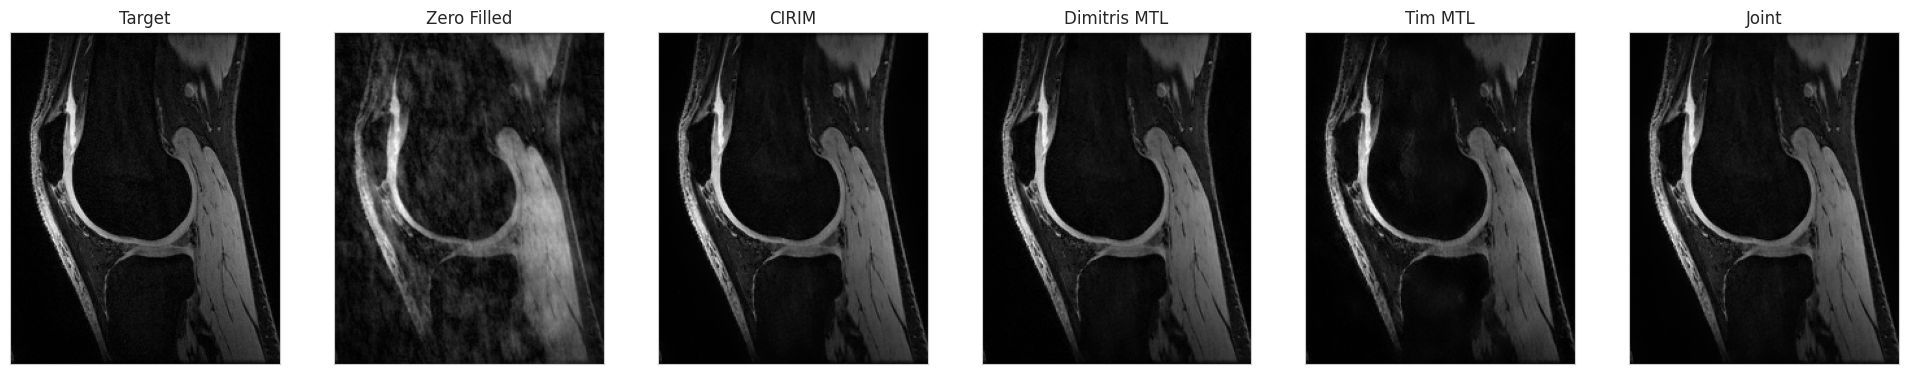

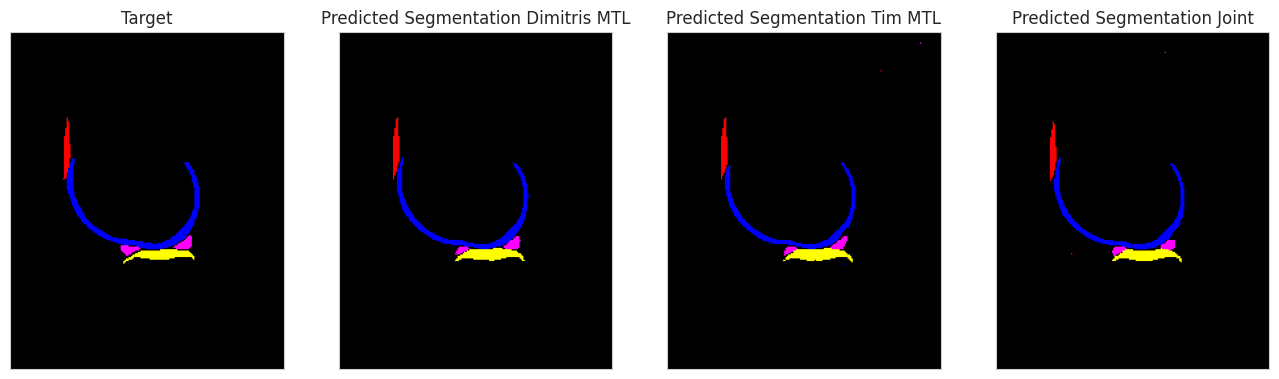

In [166]:
sl = 5
output ='stacked'

if output == 'complex_abs':
    scan_output_1 = scan_mtlrs_1[sl]**2
    target_output = target_mtlrs_1[sl]**2
    scan_output_2 = scan_mtlrs_2[sl]**2
    scan_output_3 = scan_mtlrs_3[sl]**2
    scan_output_4 = scan_cirim[sl]**2
    zero_filled_output = zero_filled_mtlrs_1[sl]**2
if output == 'complex_abs_sqrt':
    scan_output_1 = np.sqrt(scan_mtlrs_1[sl]**2)
    target_output = np.sqrt(target_mtlrs_1[sl]**2)
    scan_output_2 = np.sqrt(scan_mtlrs_2[sl]**2)
    scan_output_3 = np.sqrt(scan_mtlrs_3[sl]**2)
    scan_output_4 = np.sqrt(scan_cirim[sl]**2)
    zero_filled_output = np.sqrt(zero_filled_mtlrs_1[sl]**2)
if output == 'stacked':
    scan_output_1 = scan_mtlrs_1[sl]
    target_output = target_mtlrs_1[sl]
    scan_output_2 = scan_mtlrs_2[sl]
    scan_output_3 = scan_mtlrs_3[sl]
    scan_output_4 = scan_cirim[sl]
    zero_filled_output = zero_filled_mtlrs_1[sl]

scan_output_1_norm = np.abs(scan_output_1/np.max(np.abs(scan_output_1))).real.astype(np.float32)
target_norm = np.abs(target_output/np.max(np.abs(target_output))).real.astype(np.float32)
scan_output_2_norm = np.abs(scan_output_2 /np.max(np.abs(scan_output_2 ))).real.astype(np.float32)
scan_output_3_norm = np.abs(scan_output_3 /np.max(np.abs(scan_output_3 ))).real.astype(np.float32)
scan_output_4_norm = np.abs(scan_output_4 /np.max(np.abs(scan_output_4 ))).real.astype(np.float32)
zero_filled_norm = np.abs(zero_filled_output/np.max(np.abs(zero_filled_output))).real.astype(np.float32)


max_value = max(np.max(scan_output_1_norm)-np.min(scan_output_1_norm), np.max(target_norm)-np.min(target_norm))
SSIM_mtlrs_1 = ssim(target_norm,scan_output_1_norm,maxval=max_value)

max_value = max(np.max(scan_output_1_norm), np.max(target_norm))
HaarPSI_mtlrs_1 = haarpsi3d(target_norm,scan_output_1_norm,maxval=max_value)

max_value = max(np.max(scan_output_2_norm)-np.min(scan_output_2_norm), np.max(target_norm)-np.min(target_norm))
SSIM_mtlrs_2 = ssim(target_norm,scan_output_2_norm,maxval=max_value)

max_value = max(np.max(scan_output_2_norm), np.max(target_norm))
HaarPSI_mtlrs_2 = haarpsi3d(target_norm,scan_output_2_norm,maxval=max_value)

max_value = max(np.max(scan_output_3_norm)-np.min(scan_output_3_norm), np.max(target_norm)-np.min(target_norm))
SSIM_mtlrs_3 = ssim(target_norm,scan_output_3_norm,maxval=max_value)

max_value = max(np.max(scan_output_3_norm), np.max(target_norm))
HaarPSI_mtlrs_3 = haarpsi3d(target_norm,scan_output_3_norm,maxval=max_value)

max_value = max(np.max(scan_output_4_norm)-np.min(scan_output_4_norm), np.max(target_norm)-np.min(target_norm))
SSIM_cirim = ssim(target_norm,scan_output_4_norm,maxval=max_value)

max_value = max(np.max(scan_output_4_norm), np.max(target_norm))
HaarPSI_cirim = haarpsi3d(target_norm,scan_output_4_norm,maxval=max_value)

max_value = max(np.max(zero_filled_norm)-np.min(zero_filled_norm), np.max(target_norm)-np.min(target_norm))
SSIM_zero= ssim(target_norm,zero_filled_norm,maxval=max_value)

max_value = max(np.max(zero_filled_norm), np.max(target_norm))
HaarPSI_zero= haarpsi3d(target_norm,zero_filled_norm,maxval=max_value)

hsize = 5
wsize = hsize / scan_output_1_norm.shape[0] * scan_output_1_norm.shape[1]
print(f"Dimitris MTL {output} SSIM : {SSIM_mtlrs_1}")
print(f"Tim MTL {output} SSIM : {SSIM_mtlrs_2}")
print(f"Joint {output} SSIM : {SSIM_mtlrs_3}")
print(f"CIRIM {output} SSIM : {SSIM_cirim}")
print(f"zero filled {output} SSIM : {SSIM_zero}")
print(f"Dimitris MTL  {output} HaarPSI : {HaarPSI_mtlrs_1}")
print(f"Tim MTL {output} HaarPSI : {HaarPSI_mtlrs_2}")
print(f"Joint {output} HaarPSI : {HaarPSI_mtlrs_3}")
print(f"CIRIM {output} HaarPSI : {HaarPSI_cirim}")
print(f"zero filled {output} HaarPSI : {HaarPSI_zero}")

plot_images([target_norm, zero_filled_norm,scan_output_1_norm,scan_output_2_norm,scan_output_3_norm,scan_output_4_norm], titles=['Target', 'Zero Filled',"CIRIM", "Dimitris MTL","Tim MTL","Joint"], fontsize=12, wsize=wsize, hsize=hsize,cmap=['gray','gray','gray','gray','gray',"gray"])
#plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_reconstruction_gaussian2d_3_mtls.png')

pred_seg_1 = label2rgb(np.argmax(segmentations_mtlrs_1[sl, :, :, :],axis=0), bg_label=0)
pred_seg_2 = label2rgb(np.argmax(segmentations_mtlrs_2[sl, :, :, :],axis=0), bg_label=0)
pred_seg_3 = label2rgb(np.argmax(segmentations_mtlrs_3[sl, :, :, :],axis=0), bg_label=0)
tar_seg = label2rgb(np.argmax(segmentation_labels_org_1[sl, :, :, :],axis=0), bg_label=0)

dice_1=dice_metric(segmentation_labels_org_1[sl, :, :, :][np.newaxis],segmentations_mtlrs_1[sl, :, :, :][np.newaxis])
dice_2=dice_metric(segmentation_labels_org_1[sl, :, :, :][np.newaxis],segmentations_mtlrs_2[sl, :, :, :][np.newaxis])
dice_3=dice_metric(segmentation_labels_org_1[sl, :, :, :][np.newaxis],segmentations_mtlrs_3[sl, :, :, :][np.newaxis])
hd_1=hausdorff_distance_metric(segmentation_labels_org_1[sl, :, :, :][np.newaxis],segmentations_mtlrs_1[sl, :, :, :][np.newaxis])
hd_2=hausdorff_distance_metric(segmentation_labels_org_1[sl, :, :, :][np.newaxis],segmentations_mtlrs_2[sl, :, :, :][np.newaxis])
hd_3=hausdorff_distance_metric(segmentation_labels_org_1[sl, :, :, :][np.newaxis],segmentations_mtlrs_3[sl, :, :, :][np.newaxis])

print(f"Dimitris MTL {output} Dice : {dice_1}")
print(f"Tim MTL {output} DIce : {dice_2}")
print(f"Joint {output} Dice : {dice_3}")
print(f"Dimitris MTL  {output} HD : {hd_1}")
print(f"Tim MTL {output} HD : {hd_2}")
print(f"Joint {output} HD : {hd_3}")

plot_images([tar_seg, pred_seg_1,pred_seg_2,pred_seg_3], titles=['Target', "Predicted Segmentation Dimitris MTL","Predicted Segmentation Tim MTL","Predicted Segmentation Joint"], fontsize=12, wsize=wsize, hsize=hsize)
#plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_segmentation_MCE_BCE_gaussian2d_4x.png')